In [1]:
import requests
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
import os
import random
import plotly.express as px
warnings.filterwarnings('ignore')

# Range of years
start_year = 2013
end_year = 2022
current_year = 2023

# Set environment variables for reproducibility
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# Load the dataframe
with open('data.pickle','rb') as file:
    data = pickle.load(file)

data.shape

(5372, 311)

# Final data preprocessing

In [3]:
excluded = ['id','year','week','home_team','away_team','margin','home_points','away_points']
categorical_features = ['neutral_site', 'home_conference','away_conference']
cont_features = [c for c in data.columns.to_list() if c not in categorical_features and c not in excluded]

In [4]:
test_data = data.query("year >= 2022")
train_data = data.query("year < 2022")

vegas_rmse = mean_squared_error(test_data['spread'], test_data['margin']) ** 0.5
vegas_mae = mean_absolute_error(test_data['spread'], test_data['margin'])

y = train_data['margin']
X = train_data.drop(columns=excluded)
X_test = test_data.drop(columns=excluded)
y_test = test_data['margin']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

quantitative_features = [item for item in list(X.columns) if item not in categorical_features]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), categorical_features),  # One-hot encode categorical features
        ('num', StandardScaler(), quantitative_features),  # Standardize numerical features
    ],
    remainder='passthrough'  # Pass through any features not explicitly transformed
)

# Apply the preprocessing to the training and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_cv_scaled = preprocessor.transform(X_cv)
X_test_scaled = preprocessor.transform(X_test)
X_scaled = preprocessor.transform(X)

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

xgbModel = xgb.XGBRegressor(random_state=42)
sfs = SFS(xgbModel, 
          k_features=200, 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error',
          verbose=2,
          n_jobs=-1,
          cv=10)
sfs = sfs.fit(X_train_scaled, y_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

X_train_sfs = sfs.transform(X_train_scaled)
X_cv_sfs = sfs.transform(X_cv_scaled)
X_test_sfs = sfs.transform(X_test_scaled)

column_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
print(column_names[list(sfs.k_feature_idx_)])

print(mean_squared_error(y_cv, xgbModel.predict(X_cv_sfs)) ** 0.5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

# Begin Modeling
Goal is to get MAE sub-13

In [16]:
def train_model(X_train, y_train, X_cv, y_cv, objective='reg:squarederror', scoring='neg_mean_squared_error'):
    """
    Finds the best model for the training data

    Parameters:
    - X_train: The feature matrix.
    - y_train: The target vector.
    - scoring: Model evaluation strategy.
    """

    model = xgb.XGBRegressor(objective=objective, random_state=42)
    
    # Define a dist of hyperparameters to search
    param_dist = {
        'n_estimators': stats.randint(100, 500),    # Randomly sample between 100 and 500
        'learning_rate': stats.uniform(0.01, 0.2),  # Randomly sample from a uniform distribution between 0.01 and 0.2
        'max_depth': stats.randint(3, 6),          # Randomly sample between 3 and 6
    }
    
    # Create the RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=3, scoring=scoring, random_state=42)
 
    # Fit the grid search to the data
    random_search.fit(X_train_scaled, y_train) 
    
    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Evaluate the best model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_cv_scaled)

    mse = mean_squared_error(y_cv, y_pred)
    print(f"Mean Squared Error (MSE) of Best Model on CV Data: {mse}")
    rmse = mse**0.5
    print(f"Root Mean Squared Error (RMSE) of Best Model on CV Data: {rmse}")

    return best_model

In [17]:
# Define the number of folds (e.g., 5 or 10)
n_folds = 5

# Create a KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def plot_learning_curve(estimator, X, y, cv=kf, train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_mean_squared_error'):
    """
    Plots learning curves for a given estimator.

    Parameters:
    - estimator: The machine learning model to evaluate.
    - X: The feature matrix.
    - y: The target vector.
    - cv: Cross-validation strategy.
    - train_sizes: Array of training set sizes used to generate the curves.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Negative MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# XGBoost Models

# Neural Network Training

In [58]:
def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
        
def train_neural_network(X_train, X_cv, y_train, y_cv, model_name="NNmodel.h5"):
    # Set environment variables for reproducibility
    os.environ['PYTHONHASHSEED'] = str(42)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    lr_scheduler = LearningRateScheduler(schedule)

    X_train_NN = X_train.astype('float32')
    y_train_NN = y_train.astype('float32')
    X_cv_NN = X_cv.astype('float32')
    y_cv_NN = y_cv.astype('float32')

    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    # Build the neural network model for regression
    sequentialModel = Sequential([
        Dense(256, input_dim=X_train_NN.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    # Compile the model
    sequentialModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    # Train the model
    history = sequentialModel.fit(X_train_NN, y_train_NN, epochs=20, batch_size=32, validation_data=(X_cv_NN, y_cv_NN), callbacks=[checkpoint, lr_scheduler], verbose=1)
    neural_network_model = load_model(model_name)

    # Evaluate the model on the validation set
    predictions = neural_network_model.predict(X_cv_NN).reshape(-1)

    # Find the epoch with the best validation loss
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
    print(f"\nBest epoch: {best_epoch}")
    
    # Evaluate the model's performance on the validation set
    print(f"RMSE of Neural Network on CV Data: {mean_squared_error(y_cv_NN, predictions)**0.5}")
    print(f"MAE of Neural Network on CV Data: {mean_absolute_error(y_cv_NN, predictions)}")
    
    # Plot the learning curve
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return neural_network_model

In [ ]:
NNmodel = train_neural_network(X_train_scaled, X_cv_scaled, y_train, y_cv, model_name="NNmodel.h5")


In [60]:
# Average of the three models:
XGBmodel = xgb.XGBRegressor()
XGBmodel.load_model("XGBmodel.json")
NNmodel = load_model('NNmodel.h5')

class EnsembleModel:
    def __init__(self, xgb_model, nn_model):
        self.xgb_model = xgb_model
        self.nn_model = nn_model

    def predict(self, X):
        xgb_prediction = self.xgb_model.predict(X)
        nn_prediction = self.nn_model.predict(X.astype('float32')).reshape(-1)
        return (xgb_prediction + nn_prediction) / 2

model = EnsembleModel(xgb_model=XGBmodel, nn_model=NNmodel)

# Data Visualization

23/23 [==============================] - 0s 2ms/step


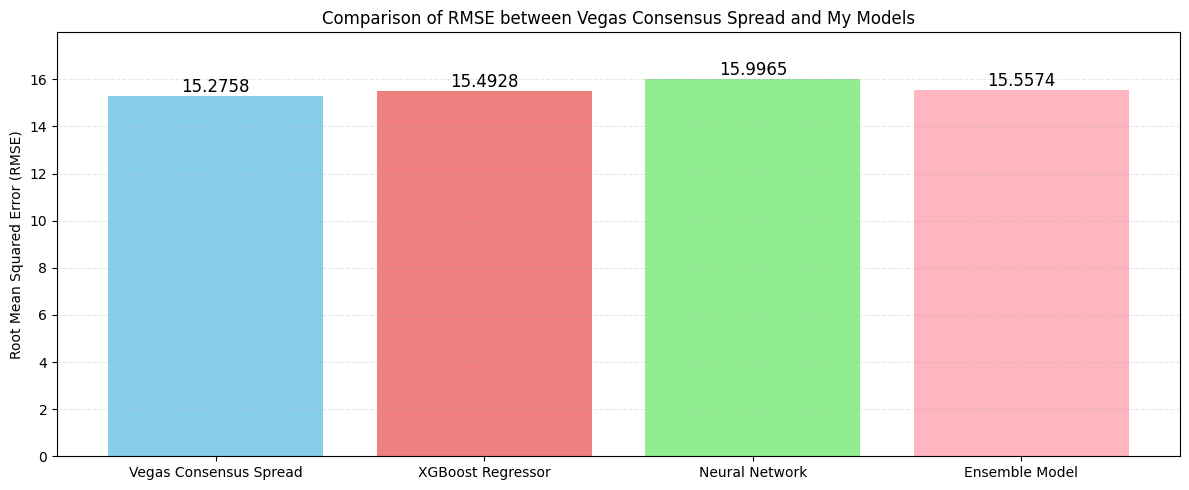

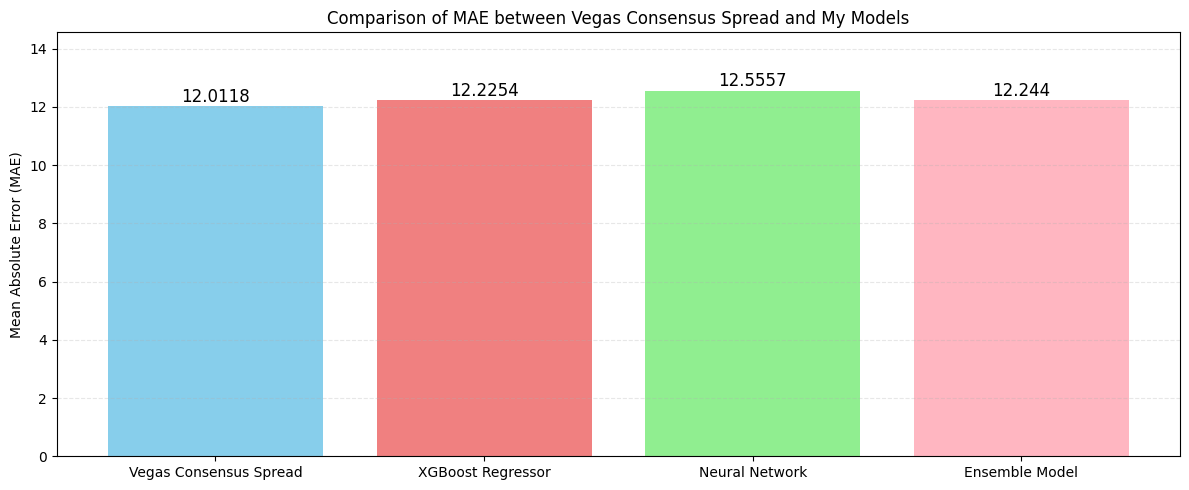

In [62]:
model_names = ['Vegas Consensus Spread', 'XGBoost Regressor', 'Neural Network', 'Ensemble Model']
XGBprediction = XGBmodel.predict(X_test_scaled)
NNprediction = NNmodel.predict(X_test_scaled.astype('float32')).reshape(-1)
averagePrediction = model.predict(X_test_scaled)

rmse_values = [vegas_rmse,
              mean_squared_error(y_test, XGBprediction) ** 0.5,
              mean_squared_error(y_test, NNprediction) ** 0.5,
              mean_squared_error(y_test, averagePrediction) ** 0.5]
mae_values = [vegas_mae,
              mean_absolute_error(y_test, XGBprediction),
              mean_absolute_error(y_test, NNprediction),
              mean_absolute_error(y_test, averagePrediction)]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightpink']

# Create a bar chart
plt.figure(figsize=(12, 5))
bars = plt.bar(model_names, rmse_values, color=colors)
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE between Vegas Consensus Spread and My Models')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add more space between the top of the bars and the outline of the chart
extra_space = 2 # Adjust this value to control the space
plt.ylim(top=max(rmse_values) + extra_space)

# Display the MAE values on top of the bars with a little offset
for bar, mae in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, mae + 0.005, str(round(mae, 4)),
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


# Create a bar chart
plt.figure(figsize=(12, 5))
bars = plt.bar(model_names, mae_values, color=colors)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE between Vegas Consensus Spread and My Models')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(top=max(mae_values) + extra_space)

# Display the MAE values on top of the bars with a little offset
for bar, mae in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, mae + 0.005, str(round(mae, 4)),
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Data Visualization

In [21]:
def plot_data(models, model_names, X, y):
    """
    Scatter Plot of Actual vs. Predicted Margins: This function generates a scatter plot to visually compare the actual margins of victory with the 
    predicted margins produced by different machine learning models. The plot assists in assessing how well the models align with the true outcomes.

    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data used for prediction.
    y: True target variable values.
    """
    
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        plt.scatter(y, y_pred, alpha=0.5, label=name)

    # Plot a diagonal red dashed line
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', lw=2)
    plt.xlabel("Margin of victory (y_cv)")
    plt.ylabel("Predicted margin of victory (y_pred)")
    plt.title("Actual vs. Predicted Margin Values for Different Models")
    plt.grid(True)
    plt.legend()
    plt.show()

In [22]:
def plot_residuals(models, model_names, X, y):
    """
    Residual Plot: This function creates a set of residual plots for evaluating the performance of multiple machine learning models. Residual plots 
    are useful for assessing how well the models' predictions align with the actual target variable values.
    
    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data.
    y: Target variable data.
    """
    
    n_models = len(models)
    n_rows = 3
    n_cols = n_models // n_rows + (n_models % n_rows > 0)
    figsize = (15, 8)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4)
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        ax = axes[i-1] if n_rows > 1 else axes
        
        y_pred = model.predict(X).ravel()
        residuals = y.ravel() - y_pred
        
        ax.scatter(y_pred, residuals, alpha=0.5, label=name)
        ax.axhline(y=0, color='red', linestyle='--', lw=2)  # Add a horizontal line at y=0
        ax.set_xlabel("Predicted Values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot - {name}")
        ax.grid(True)
        ax.legend()
        
        # Set x-axis and y-axis scales to be the same
        min_val = min(y_pred.min(), residuals.min())
        max_val = max(y_pred.max(), residuals.max())
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    plt.show()

In [23]:
def plot_distributions(models, model_names, X, y):
    """
    Distribution Plot: This function generates a set of distribution plots for comparing the actual and predicted values from multiple machine learning models. 
    The plots showcase the distribution of values, providing insights into how well each model captures the underlying patterns in the data.
    
    Parameters:
    models: List of machine learning models to evaluate.
    model_names: List of names corresponding to each model.
    X: Feature data.
    y: Target variable data.
    """
    
    n_models = len(models)
    n_rows = 3
    n_cols = n_models // n_rows + (n_models % n_rows > 0)
    figsize = (15, 8)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4)
    
    axes = axes.ravel()  # Flatten axes for easier indexing
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        ax = axes[i-1]
        y_pred = model.predict(X).ravel()
        
        sns.kdeplot(y.ravel(), label="Actual", fill=True, ax=ax)
        sns.kdeplot(y_pred, label=f"{name} Predicted", fill=True, ax=ax)
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.set_title(f"Distribution Plot (Actual vs. {name} Predicted)")
        ax.legend()
        ax.grid(True)
    plt.show()

In [24]:
def get_feature_importances(model, column_names, n_features=100):
    """
    Importance Score Plot: This plot represents the importance of each feature based on the number of times they are used for splitting across all 
    decision trees.

    F-Score Plot: This plot represents the importance of each feature based on the "weight," which is the number of times a feature appears in a 
    tree across all boosting rounds.

    While both plots provide an indication of feature importance, they may not necessarily give the same ranking because they focus on different 
    aspects of the boosting process. The Importance Score is based on the number of times a feature is used for splitting, while the F-Score 
    considers the number of times a feature appears across all boosting rounds.
    
    Parameters:
    - model: XGBoost machine learning model to evaluate.
    - column_names: Column names.
    - n_features: How many features to plot.
    """
    
    # Importance Score Plot
    importance_scores = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': column_names, 'Importance': importance_scores})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    top_features = feature_importances.head(n_features)
    top_features = top_features[::-1]

    plt.figure(figsize=(10, min(n_features, 24)))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'XGBoost Regressor: Importance Score Plot')
    plt.show()

    # F-Score Plot
    weights = model.get_booster().get_fscore()  
    weights_with_names = {column_names[int(key[1:])]: value for key, value in weights.items()}
    sorted_weights = sorted(weights_with_names.items(), key=lambda x: x[1], reverse=True)
    top_features_by_weight = dict(sorted_weights[:n_features])
    
    plt.figure(figsize=(10, min(n_features, 24)))
    plt.barh(list(top_features_by_weight.keys())[::-1], list(top_features_by_weight.values())[::-1])
    plt.xlabel('F-Score')
    plt.ylabel('Features')
    plt.title(f'XGBoost Regressor: F-Score Plot')
    plt.show()

    # Combine and average the importance scores
    averaged_importances = {}
    zero_importance_features = []

    for column in column_names:
        importance = (importance_scores[column_names == column].sum() +
                      weights_with_names.get(column, 0)) / 2.0
        averaged_importances[column] = importance
        if importance < 0.01:
            zero_importance_features.append(column)
    n_most_important_features = sorted(averaged_importances, key=averaged_importances.get, reverse=True)[:n_features]
    
    return n_most_important_features, zero_importance_features

In [25]:
def plot_heatmap(X):
    """
    Error Heatmap: This function generates a heatmap to visualize the correlation matrix of features, helping to identify feature interactions affecting the model.

    Parameters:
    - X: DataFrame containing the features.
    """

    fig = px.imshow(X.corr(), x=X.columns, y=X.columns)
    
    # Customize hover information
    fig.update_layout(
        xaxis=dict(tickvals=list(range(len(X.columns))), ticktext=X.columns),
        yaxis=dict(tickvals=list(range(len(X.columns))), ticktext=X.columns),
        hovermode="closest",
    )
    
    fig.update_traces(hoverinfo="all", hovertemplate="Feature 1: %{y}<br>Feature 2: %{x}<br>Correlation: %{z}")
    fig.update_layout(coloraxis_colorscale='viridis')
    
    # Adjust figure size and title
    fig.update_layout(
        width=1200,  # Adjust the width as needed
        height=1200,  # Adjust the height as needed
        title_text="Error Heatmap for Top Features",
    )
    
    # Adjust font size and rotation
    fig.update_layout(
        xaxis=dict(tickangle=-90, tickfont=dict(size=10)),
        yaxis=dict(tickfont=dict(size=10)),
    )

    fig.show()

In [26]:
models = [XGBmodel, NNmodel, model]
model_names = ['XGBoost Regressor', 'Neural Network', 'Ensemble Model']
column_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
X_cv_scaled_with_column_names = pd.DataFrame(X_cv_scaled, columns=column_names)

# plot_data(models, model_names, X_cv_scaled, y_cv)
# plot_residuals(models, model_names, X_cv_scaled, y_cv)
# plot_distributions(models, model_names, X_cv_scaled, y_cv)
# n_most_important_features, zero_importance_features = get_feature_importances(XGBmodel, column_names, 100)
# plot_heatmap(X_cv_scaled_with_column_names[n_most_important_features])

# X_cv_important_features = pd.DataFrame(X_cv_scaled, columns=column_names)
# X_cv_important_features = X_cv_important_features[n_most_important_features].values
# X_train_important_features = pd.DataFrame(X_train_scaled, columns=column_names)
# X_train_important_features = X_train_important_features[n_most_important_features].values

# Run the model(s) on the test data

In [33]:
X_test.head()

,neutral_site,home_conference,away_conference,spread,home_elo,away_elo,home_talent,away_talent,home_ap_top_25_points,away_ap_top_25_points,...,home_relative_avg_rushing_ypc_past_1_years,away_relative_avg_rushing_ypc_past_1_years,home_relative_avg_rushing_ypc_past_2_years,away_relative_avg_rushing_ypc_past_2_years,home_relative_avg_rushing_ypc_allowed_cumulative,away_relative_avg_rushing_ypc_allowed_cumulative,home_relative_avg_rushing_ypc_allowed_past_1_years,away_relative_avg_rushing_ypc_allowed_past_1_years,home_relative_avg_rushing_ypc_allowed_past_2_years,away_relative_avg_rushing_ypc_allowed_past_2_years
4650,True,Big Ten,Big Ten,12.5,1361.0,1636.0,653.48,752.12,0,0,...,-0.018838,0.142482,-0.049002,0.203103,0.0,0.0,0.275722,-0.031318,0.107024,0.002604
4651,False,Mountain West,FBS Independents,-24.0,1566.0,1117.0,371.37,239.17,0,0,...,-0.107613,-0.179608,-0.035630,-0.191203,0.0,0.0,0.074965,0.142719,0.159931,0.174228
4652,False,Big Ten,Mountain West,-14.0,1496.0,1497.0,631.46,292.03,0,0,...,0.067682,0.178714,0.145695,0.146082,0.0,0.0,-0.057489,0.182531,0.083895,0.098468
4653,False,Conference USA,Conference USA,1.5,1360.0,1426.0,289.39,504.97,0,0,...,-0.117481,0.108608,-0.175157,0.127852,0.0,0.0,0.000821,0.024786,-0.013043,0.194864
4654,False,FBS Independents,Mountain West,7.0,1184.0,1564.0,189.37,416.44,0,0,...,-0.260102,-0.372285,-0.295638,-0.232522,0.0,0.0,0.461046,0.130226,0.399887,0.082617


In [66]:
y_pred = model.predict(X_test_scaled)

print(f"RMSE of Ensemble Model on test data: {mean_squared_error(y_test, y_pred)**0.5}")
print(f"RMSE of Vegas on test data: {mean_squared_error(y_test, X_test['spread'])**0.5}")
print(f"MAE of Ensemble Model on test data: {mean_absolute_error(y_test, y_pred)}")
print(f"MAE of Vegas on test data: {mean_absolute_error(y_test, X_test['spread'])}\n")

# X_test.insert(X_test.columns.get_loc('spread') + 1, 'predicted', y_pred)
# X_test.insert(X_test.columns.get_loc('predicted') + 1, 'margin', y_test)

spread_values = X_test['spread'].values
model_vs_vegas_results = np.where(y_test < spread_values, y_pred < spread_values, y_pred > spread_values)
# display(X_test[model_vs_vegas_results])

for spread_difference in range(0,21):
    selected_indices = np.abs(spread_values - y_pred) >= spread_difference

    selected_games = X_test[selected_indices]
    print(f"Number of games |model-vegas| >= {spread_difference}: {len(selected_games)}")

    selected_games_spreads = selected_games['spread'].values
    y_pred_selected_games = y_pred[selected_indices]
    y_test_selected_games = y_test[selected_indices]
    
    model_vs_vegas_confident_results = np.where(y_test_selected_games < selected_games_spreads, y_pred_selected_games < selected_games_spreads, y_pred_selected_games > selected_games_spreads)
    print(f"Ensemble Model Win PCT: {(model_vs_vegas_confident_results.mean()) * 100:.2f}%\n")

week_values = X_test['week'].values
for week in range(0,18):
    selected_indices = week_values == week

    selected_games = X_test[selected_indices]
    print(f"Number of games in week {len(selected_games)}")

    selected_games_spreads = selected_games['spread'].values
    y_pred_selected_games = y_pred[selected_indices]
    y_test_selected_games = y_test[selected_indices]
    
    model_vs_vegas_confident_results = np.where(y_test_selected_games < selected_games_spreads, y_pred_selected_games < selected_games_spreads, y_pred_selected_games > selected_games_spreads)
    print(f"Ensemble Model Win PCT: {(model_vs_vegas_confident_results.mean()) * 100:.2f}%\n")

23/23 [==============================] - 0s 2ms/step
RMSE of Ensemble Model on test data: 15.557429175221046
RMSE of Vegas on test data: 15.27575478366049
MAE of Ensemble Model on test data: 12.24395517488926
MAE of Vegas on test data: 12.011772853185596

Number of games |model-vegas| >= 0: 722
Ensemble Model Win PCT: 48.75%

Number of games |model-vegas| >= 1: 534
Ensemble Model Win PCT: 50.56%

Number of games |model-vegas| >= 2: 388
Ensemble Model Win PCT: 48.97%

Number of games |model-vegas| >= 3: 240
Ensemble Model Win PCT: 50.00%

Number of games |model-vegas| >= 4: 130
Ensemble Model Win PCT: 48.46%

Number of games |model-vegas| >= 5: 70
Ensemble Model Win PCT: 47.14%

Number of games |model-vegas| >= 6: 40
Ensemble Model Win PCT: 42.50%

Number of games |model-vegas| >= 7: 23
Ensemble Model Win PCT: 34.78%

Number of games |model-vegas| >= 8: 14
Ensemble Model Win PCT: 35.71%

Number of games |model-vegas| >= 9: 8
Ensemble Model Win PCT: 37.50%

Number of games |model-vegas| 

KeyError: 'week'